<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[DATA] train=1450  val=450  test=950  (win=50)
Epoch 01/20 | train MSE=0.895245 | val MSE=0.695817
Epoch 02/20 | train MSE=0.540697 | val MSE=0.351662
Epoch 03/20 | train MSE=0.256731 | val MSE=0.100167
Epoch 04/20 | train MSE=0.045619 | val MSE=0.034136
Epoch 05/20 | train MSE=0.023299 | val MSE=0.015047
Epoch 06/20 | train MSE=0.016680 | val MSE=0.010322
Epoch 07/20 | train MSE=0.013535 | val MSE=0.009545
Epoch 08/20 | train MSE=0.011627 | val MSE=0.008882
Epoch 09/20 | train MSE=0.011527 | val MSE=0.008332
Epoch 10/20 | train MSE=0.010865 | val MSE=0.008318
Epoch 11/20 | train MSE=0.010472 | val MSE=0.007750
Epoch 12/20 | train MSE=0.010208 | val MSE=0.008479
Epoch 13/20 | train MSE=0.010198 | val MSE=0.007748
Epoch 14/20 | train MSE=0.009932 | val MSE=0.007954
Epoch 15/20 | train MSE=0.009523 | val MSE=0.007547
Epoch 16/20 | train MSE=0.009240 | val MSE=0.007179
Epoch 17/20 | train MSE=0.009274 | val MSE=0.007192
Epoch 18/20 | train MSE=0.008679 | val MSE=0.007251
Epoch 19/20 | tra

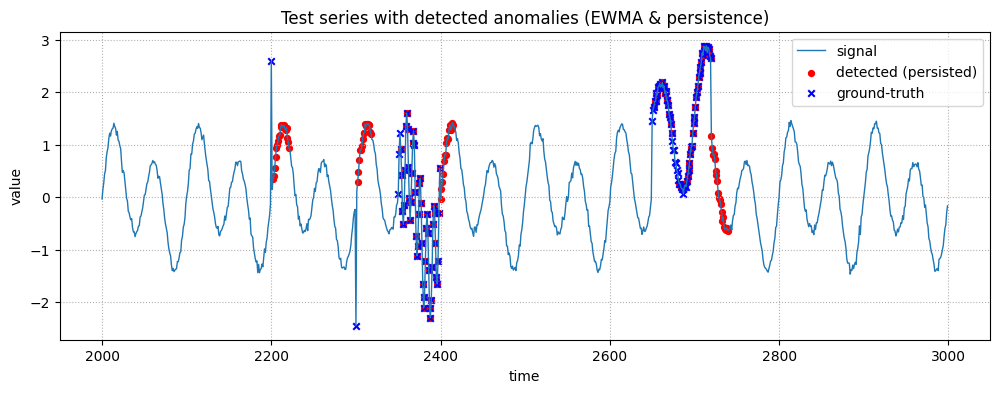

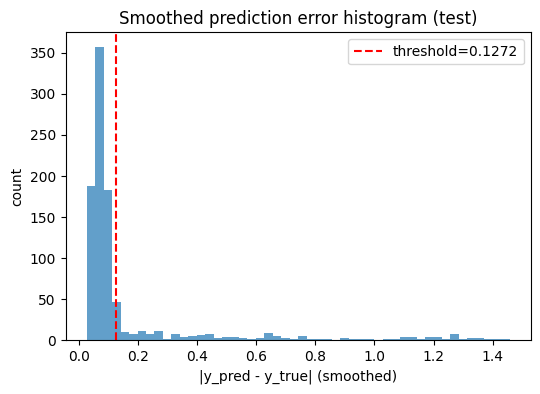

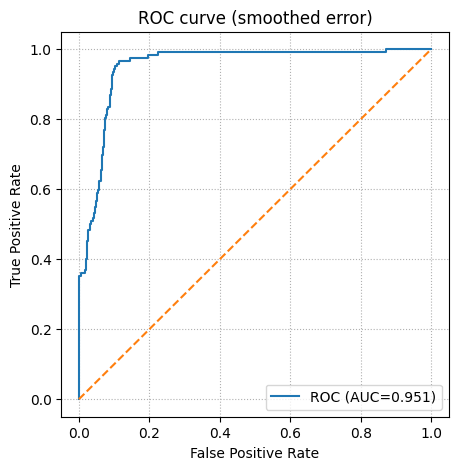


Notes:
- LSTM forecaster trained on normal-only. Anomaly score = absolute prediction error (optionally EWMA-smoothed).
- Threshold from validation-normal via quantile or robust MAD; persistence filter reduces false positives.
- Tune: THRESH_PCT↑ / MAD_SCALE↑ for fewer FPs; increase PERSIST_K; adjust SMOOTH_ALPHA.
- Swap to sequence reconstruction (LSTM-AE) by training to reconstruct window and using window MSE.



In [2]:
# Colab one-cell: LSTM による時系列異常検知（過検出対策つき・予測誤差ベース）
# 仕様
# - コメントは日本語、グラフのタイトルやラベルは英語
# - 正常データのみで LSTM 予測器（次時点予測）を学習
# - 異常スコア = 予測誤差（|y_pred - y_true|）を平滑化（EWMA）
# - しきい値 = 検証（正常）誤差から分位点 or MAD（ロバスト）
# - 連続検出（persistence）で FP を削減
# - 可視化: テスト系列 + 検出点, 誤差ヒスト + しきい値, ROC 曲線

import numpy as np, math, random, time, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# 評価指標（未インストールなら導入）
try:
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "scikit-learn"])
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc

# ===== ハイパーパラメータ =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE == "cuda": torch.cuda.manual_seed_all(SEED)

# データ長・分割
N = 3000                 # 全系列長
TR_END = 1500            # 学習終了インデックス
VAL_END = 2000           # 検証終了インデックス
TE_END  = N              # テスト終了インデックス

# 学習・モデル
WIN = 50                 # 入力窓長（過去 WIN ステップで次ステップを予測）
BATCH = 128
EPOCHS = 20
LR = 1e-3
HID = 64                 # LSTM 隠れ次元
LAYERS = 2               # LSTM 層数
DROPOUT = 0.1

# 過検出対策（しきい値/平滑/連続）
THRESH_MODE = "quantile" # "quantile" または "mad"
THRESH_PCT  = 99.7       # 分位点（厳しめ: 99.5〜99.9）
MAD_SCALE   = 3.5        # MAD のスケール（3.0〜4.5）
SMOOTH_ALPHA = 0.2       # EWMA 平滑（0 で無効, 0.1〜0.4 推奨）
PERSIST_K    = 3         # 連続 K 点以上で異常とみなす

# ===== 合成データ（正常 + 異常） =====
# 正常: 複合サイン + わずかなノイズ
t = np.arange(N)
x = (np.sin(2*np.pi*t/50) + 0.5*np.sin(2*np.pi*t/100) + 0.05*np.random.randn(N)).astype(np.float32)

# 異常ラベル（0=正常, 1=異常）
labels = np.zeros(N, dtype=int)

# テスト区間に異常を注入（尖り, レベルシフト, 周波数バースト）
def add_spike(idx, amp):
    x[idx] += amp; labels[idx] = 1
def add_level_shift(start, end, shift):
    x[start:end] += shift; labels[start:end] = 1
def add_freq_burst(start, end, amp=1.0, period=10):
    x[start:end] += amp*np.sin(2*np.pi*np.arange(end-start)/period)
    labels[start:end] = 1

# テスト領域にのみ異常を追加（学習/検証は正常前提）
add_spike(2200, +2.5)
add_spike(2300, -2.5)
add_freq_burst(2350, 2400, amp=1.0, period=8)
add_level_shift(2650, 2720, shift=+1.5)

# ===== 標準化（学習区間の統計のみ使用） =====
mu = x[:TR_END].mean().item()
sd = x[:TR_END].std().item() + 1e-8
xz = (x - mu) / sd

# ===== スライディング窓データセット作成（x[t-WIN:t] -> x[t]） =====
def make_xy(arr, start, end, win):
    xs, ys, idx = [], [], []
    for t_ in range(start+win, end):
        xs.append(arr[t_-win:t_])
        ys.append(arr[t_])
        idx.append(t_)
    X = np.array(xs, dtype=np.float32)[..., None]   # [N, WIN, 1]
    y = np.array(ys, dtype=np.float32)[..., None]   # [N, 1]
    idx = np.array(idx, dtype=int)                  # 元の時刻インデックス
    return X, y, idx

Xtr, ytr, idx_tr = make_xy(xz, 0, TR_END, WIN)
Xva, yva, idx_va = make_xy(xz, TR_END, VAL_END, WIN)
Xte, yte, idx_te = make_xy(xz, VAL_END, TE_END, WIN)

def mk_loader(X, y, bs=BATCH, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=0, pin_memory=(DEVICE=="cuda"))

ld_tr = mk_loader(Xtr, ytr, BATCH, True)
ld_va = mk_loader(Xva, yva, max(256, BATCH), False)
ld_te = mk_loader(Xte, yte, 256, False)

print(f"[DATA] train={len(Xtr)}  val={len(Xva)}  test={len(Xte)}  (win={WIN})")

# ===== モデル定義：LSTM 予測器 =====
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim=1, hid=64, layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hid,
                            num_layers=layers, dropout=dropout, batch_first=True)
        self.head = nn.Linear(hid, 1)
    def forward(self, x):                 # x: [B, T, 1]
        out, _ = self.lstm(x)             # out: [B, T, H]
        h_last = out[:, -1, :]            # 最終時刻の隠れ状態
        yhat = self.head(h_last)          # 次時点の予測値
        return yhat

model = LSTMForecaster(hid=HID, layers=LAYERS, dropout=DROPOUT).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
crit = nn.MSELoss()

# ===== 学習 =====
best_va = float("inf")
for ep in range(1, EPOCHS+1):
    model.train(); tr_loss = 0.0; n = 0
    for xb, yb in ld_tr:
        xb = xb.to(DEVICE, non_blocking=True); yb = yb.to(DEVICE, non_blocking=True)
        pred = model(xb)
        loss = crit(pred, yb)
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        bs = xb.size(0); tr_loss += float(loss)*bs; n += bs
    # 検証
    model.eval(); va_loss = 0.0; m = 0
    with torch.no_grad():
        for xb, yb in ld_va:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            pred = model(xb)
            loss = crit(pred, yb)
            bs = xb.size(0); va_loss += float(loss)*bs; m += bs
    tr_loss /= max(1,n); va_loss /= max(1,m)
    best_va = min(best_va, va_loss)
    print(f"Epoch {ep:02d}/{EPOCHS} | train MSE={tr_loss:.6f} | val MSE={va_loss:.6f}")

# ===== 推論（予測と誤差） =====
def predict_all(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            yhat = model(xb)
            preds.append(yhat.cpu().numpy())
            trues.append(yb.cpu().numpy())
    pred = np.concatenate(preds, 0).squeeze(-1)
    true = np.concatenate(trues, 0).squeeze(-1)
    return pred, true

pred_va, true_va = predict_all(ld_va)
pred_te, true_te = predict_all(ld_te)

# 絶対誤差（標準化空間）
err_va = np.abs(pred_va - true_va)
err_te = np.abs(pred_te - true_te)

# ===== 誤差の平滑化（EWMA） =====
def ewma(x, alpha):
    if alpha <= 0: return x
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    return y

err_va_s = ewma(err_va, SMOOTH_ALPHA)
err_te_s = ewma(err_te, SMOOTH_ALPHA)

# ===== しきい値の決定（検証：正常のみ） =====
if THRESH_MODE.lower() == "mad":
    med = np.median(err_va_s)
    mad = np.median(np.abs(err_va_s - med)) + 1e-8
    thr = med + MAD_SCALE * 1.4826 * mad
else:
    thr = np.percentile(err_va_s, THRESH_PCT)
print(f"[THRESH] mode={THRESH_MODE}  pct={THRESH_PCT}  alpha={SMOOTH_ALPHA}  persist_k={PERSIST_K}  -> thr={thr:.6f}")

# ===== 連続検出フィルタ（k 連続で初めて 1） =====
def apply_persistence(scores, thr, k):
    above = (scores >= thr).astype(int)
    if k <= 1: return above
    kernel = np.ones(k, dtype=int)
    conv = np.convolve(above, kernel, mode='valid')
    mask_valid = (conv == k).astype(int)
    mask = np.zeros_like(above)
    mask[k-1:] = mask_valid           # 連続確定の終端に印を置く
    return mask

# 評価用配列（idx_te に対応する点ラベルを使用）
y_true_pts = labels[idx_te]
y_score_pts = err_te_s
y_pred_pts = apply_persistence(y_score_pts, thr, PERSIST_K)

# ===== 評価（AUC/AP/Acc） =====
auc_v = roc_auc_score(y_true_pts, y_score_pts)
ap_v  = average_precision_score(y_true_pts, y_score_pts)
fpr, tpr, _ = roc_curve(y_true_pts, y_score_pts)
acc = (y_pred_pts == y_true_pts).mean()
print(f"[EVAL] AUC={auc_v:.4f}  AP={ap_v:.4f}  Acc@thr+persist={acc:.4f}")

# ===== 可視化 =====
# 1) テスト系列 + 検出点（赤） + 真の異常（青×）
te_range = np.arange(VAL_END, TE_END)
plt.figure(figsize=(12,4))
plt.plot(te_range, x[VAL_END:TE_END], lw=1.0, label="signal")
det_indices = idx_te[y_pred_pts.astype(bool)]
det_in_plot = det_indices - VAL_END
plt.scatter(te_range[det_in_plot], x[det_indices], s=18, c="red", label="detected (persisted)")
gt_in_plot = np.where(labels[VAL_END:TE_END] == 1)[0]
plt.scatter(te_range[gt_in_plot], x[VAL_END:TE_END][gt_in_plot], s=22, marker="x", c="blue", label="ground-truth")
plt.title("Test series with detected anomalies (EWMA & persistence)")
plt.xlabel("time"); plt.ylabel("value"); plt.legend(); plt.grid(True, linestyle=":")
plt.show()

# 2) 誤差ヒストグラム + しきい値（平滑後）
plt.figure(figsize=(6,4))
plt.hist(y_score_pts, bins=50, alpha=0.7)
plt.axvline(thr, color="red", linestyle="--", label=f"threshold={thr:.4f}")
plt.title("Smoothed prediction error histogram (test)")
plt.xlabel("|y_pred - y_true| (smoothed)"); plt.ylabel("count"); plt.legend()
plt.show()

# 3) ROC 曲線（平滑後スコア）
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC curve (smoothed error)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True, linestyle=":")
plt.show()

print("""
Notes:
- LSTM forecaster trained on normal-only. Anomaly score = absolute prediction error (optionally EWMA-smoothed).
- Threshold from validation-normal via quantile or robust MAD; persistence filter reduces false positives.
- Tune: THRESH_PCT↑ / MAD_SCALE↑ for fewer FPs; increase PERSIST_K; adjust SMOOTH_ALPHA.
- Swap to sequence reconstruction (LSTM-AE) by training to reconstruct window and using window MSE.
""")
